# CORTX Metrics Executive Report

To best realize CORTX’s potential to reduce software costs and allow users to purchase more storage with their data center budgets, CORTX is 100% open source software. To maximize its utility, a vibrant engaged community is essential. This report describes and quantifies multiple goals for CORTX Community to allow us to identify opportunities for improvement so that we can best apply our resources.

CORTX Community goals are divided into four main categories: 

1. Awareness 
    * Ensuring that CORTX is known; positioning CORTX as useful, innovative, and interesting 
2. Community Development
    * Ensuring the community can attract and retain potential contributors 
3. Project Development
    * Ensuring the community can and does contribute to the development of CORTX 
4. Adoption 
    * Ensuring the project supports and encourages implementation

This report is accordingly split into 4 sections (one for each category). Within each category, we track dozens of metrics but in this report, we focus merely on just a few select metrics for each category which we feel present the most meaningful, yet concise, overview of CORTX Community.

## Awareness

Within Awareness, our topline metrics are as follows: 

1. Github Visits/Views (weekly average) 
2. Newsletter Subscriptions 
3. Seagate domain Referrals

For two of these, we can make a graph using data scraped from github.

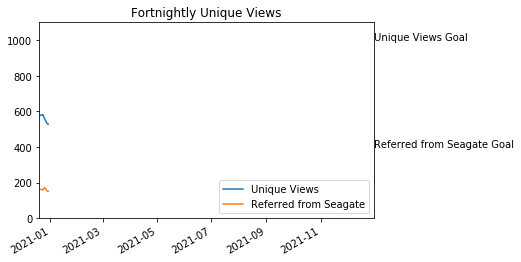

In [2]:
%matplotlib inline
import cortx_community as cc
import cortx_graphing as cg
import datetime
import matplotlib.pyplot as plt
ps=cc.PersistentStats()
df=cg.get_dataframe(ps=ps,repo='GLOBAL')
title='Fortnightly Unique Views'
df['Unique Views']=df['views_unique_14_days']
df['Referred from Seagate'] = df['seagate_referrer_uniques'] + df['seagate_blog_referrer_uniques']
columns=['Unique Views','Referred from Seagate']
goal_date=datetime.datetime(2021,12,31,0,0,0)
xlim=(None,goal_date)
ylim=(0,1100)
goal1 = cg.Goal('Unique Views Goal', goal_date,1000)
goal2 = cg.Goal('Referred from Seagate Goal', goal_date, 400)
plt = cg.goal_graph(df=df,title=title,xlim=xlim,ylim=ylim,goals=[goal1,goal2],columns=columns)
plt.show()

## Community Development

Within community development, our topline metrics are as follows:

1. Slack Total Members
2. Slack WAU average
3. Webinar Attendance
4. Github Engaged Members (Innersource + External)

Of these, only one is currently in our automatically scraped data:

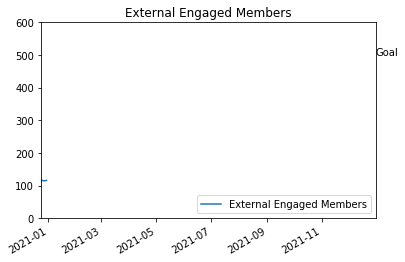

In [3]:
title='External Engaged Members'
df[title] = df['innersource_participants'] + df['external_participants']
start_date=datetime.datetime(2020,12,24,0,0,0)
goal_date=datetime.datetime(2021,12,31,0,0,0)
xlim=(start_date,goal_date)
ylim=(0,600)
plt=cg.goal_graph(df=df,title=title,xlim=xlim,ylim=ylim,goals=[cg.Goal('Goal',goal_date,500)],columns=[title])
plt.show()

## Project Development

Within project development, our topline metrics are as follows:

1. Submissions (issues + PRs)
2. Merged PRs
3. Acceptance Rate of External PR's

Of these, all can be plotted from our automatically scraped data:

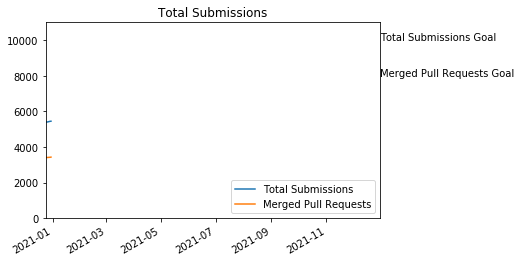

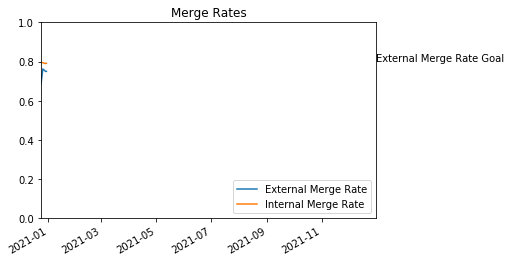

In [13]:
ts='Total Submissions'
mp='Merged Pull Requests'
mr='Merge Rate'
df['Total Submissions'] = df['pull_requests']+df['issues']
df['Merged Pull Requests'] = df ['pull_requests_merged']
mr_columns=[]
for k in ['external','internal']:
    mr_column=('%s merge rate' % k).title()
    df[mr_column] = df['pull_requests_%s_merged' % k] / df['pull_requests_%s' % k]
    mr_columns.append(mr_column)
start_date=datetime.datetime(2020,12,24,0,0,0)
goal_date=datetime.datetime(2021,12,31,0,0,0)
xlim=(start_date,goal_date)
ylim=(0,11000)
columns=['Total Submissions','Merged Pull Requests']
ts_goal=cg.Goal('Total Submissions Goal',goal_date,10000)
mp_goal=cg.Goal('Merged Pull Requests Goal',goal_date,8000)
plt=cg.goal_graph(df=df,title=ts,xlim=xlim,ylim=ylim,columns=columns,goals=[ts_goal,mp_goal])
plt.show()
mr_goal=cg.Goal('External Merge Rate Goal',goal_date,0.8)
plt1=cg.goal_graph(df=df,title='Merge Rates',xlim=xlim,ylim=(0,1),columns=mr_columns,goals=[mr_goal])
plt1.show()